In [68]:
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MeanShift, DBSCAN, estimate_bandwidth
from collections import Counter



## Import Pre-Proccessed Data:

In [69]:
data = pd.read_csv("dataset_final.csv")

In [70]:
data.columns

Index(['ID', 'Age', 'UseByTime', 'AthleticsActivities', 'WaterActivities',
       'FitnessActivities', 'TeamActivities', 'RacketActivities',
       'CombatActivities', 'SpecialActivities', 'OtherActivities', 'Dropout',
       'Contract_Duration', 'PercentageOfVisits', 'PercentageOfClasses',
       'Freq_Visits_Day', 'Freq_Classes_Contract', 'Visits_ActivePeriod',
       'Gender_Female'],
      dtype='object')

We now need to separate the different types of features we have:

In [71]:
metric_features = ['Age','Contract_Duration', 'PercentageOfVisits', 'PercentageOfClasses',
       'Freq_Visits_Day', 'Freq_Classes_Contract', 'Visits_ActivePeriod']

non_metric_features = data.columns.drop(metric_features).to_list()

In [72]:
activities = ['AthleticsActivities', 'WaterActivities','FitnessActivities','TeamActivities','RacketActivities','CombatActivities','SpecialActivities','OtherActivities']

In [91]:
attendance_perspective = ['Age', 'Contract_Duration', 'PercentageOfVisits', 'PercentageOfClasses',
       'Freq_Visits_Day', 'Visits_ActivePeriod']
compare = ['UseByTime','Dropout', 'Gender_Female']
df_activities = data[activities].copy()
df_attendance = data[attendance_perspective].copy()
df_compare = data[compare].copy()

## Removing Outliers with DBSCAN:

In [74]:
dbscan = DBSCAN(eps=2.25, min_samples = 2 * len(metric_features), n_jobs = -1)
dbscan_labels = dbscan.fit_predict(data[metric_features])

data = pd.concat([data, pd.Series(dbscan_labels, name = 'dbscan_labels', index = data.index)], axis =1)

Counter(dbscan_labels)

Counter({0: 14644, -1: 129})

In [75]:
data_dbscan_out = data[dbscan_labels == -1]
data = data[dbscan_labels != -1]

In [76]:
data.shape

(14644, 20)

In [12]:
df_attendance = data[attendance_perspective].copy()

## Density Based Clustering

In [13]:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

### Mean Shift Clustering:

This algorithm is robust to outliers but has poor scalabily.

We can estimate the bandwith parameter directly using the **estimate_bandwith** function from *sklearn.cluster*

In [14]:
bandwidth = estimate_bandwidth(df_attendance, quantile=0.17, random_state=1, n_jobs=-1)
bandwidth

2.0213006812943033

In [15]:
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=4)
ms_labels = ms.fit_predict(df_attendance)

ms_n_clusters = len(np.unique(ms_labels))
print("Number of estimated clusters : %d" % ms_n_clusters)

Number of estimated clusters : 4


In [16]:
Counter(ms_labels)

Counter({0: 10937, 1: 3343, 2: 349, 3: 15})

This model does no give good results for our data. 

In [17]:
df_concat = pd.concat([df_attendance, pd.Series(ms_labels, index=data.index, name="ms_labels")], axis=1)
df_concat.head()

,Age,Contract_Duration,PercentageOfVisits,PercentageOfClasses,Freq_Visits_Day,Visits_ActivePeriod,ms_labels
0,3.083333,-0.490868,1.15,1.866571,0.763419,-0.201465,0
1,0.500000,0.285388,-0.20,0.104392,-0.204771,-0.501832,0
2,0.000000,-0.554795,0.50,0.000000,1.208748,0.619048,0
3,-1.166667,-0.257991,0.35,0.239981,0.463221,-0.300366,0
4,1.000000,1.152968,-0.50,0.000000,-0.255467,-0.600733,0


In [18]:
# Computing the R^2 of the cluster solution
sst = get_ss(df_attendance)  # get total sum of squares
ssw_labels = df_concat.groupby(by='ms_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.3094


## DBSCAN:

In [19]:
dbscan = DBSCAN(eps = 0.5, min_samples = len(attendance_perspective)*3)
dbscan_labels = dbscan.fit_predict(df_attendance)


dbscan_n_clusters = len(np.unique(dbscan_labels))
print("Number of estimated clusters : %d" % dbscan_n_clusters)

Counter(dbscan_labels)

Number of estimated clusters : 5


Counter({0: 8388, -1: 4582, 1: 1625, 2: 31, 3: 18})

In [20]:
# Computing the R^2 of the cluster solution
sst = get_ss(df_attendance)  # get total sum of squares
ssw_labels = df_concat.groupby(by='ms_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.3094


DBSCAN struggles with clusters of similar density, which might indicate our data has relatively similar density.

## GMM

**Gaussian Mixture Models** help represent normally distributed subpopulations within an overall population.\
It is a good model to use when clusters have different sizes, shapes, and orientations, so it is a possible approach to comprehend clusters we couldn't find before.

We need to define the **covariance_type** hyperparameter, that defines the degree of freedom in the shape of each cluster and the **n_components**:

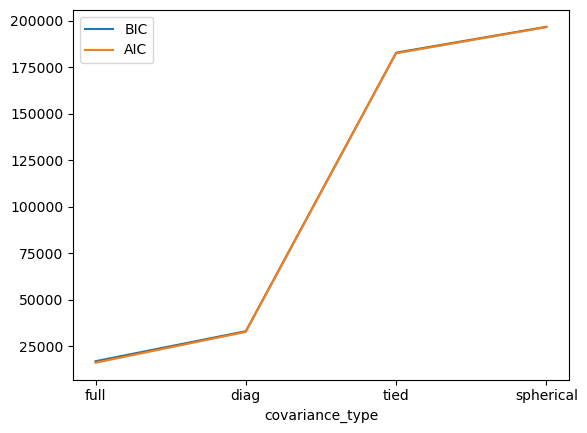

In [21]:
# Selecting covariance type based on AIC and BIC
cov_type = ['full','diag', 'tied', 'spherical']
models = [GaussianMixture(n_components=4, covariance_type=t, n_init=10, random_state=1).fit(df_attendance)
          for t in cov_type]

# TO-DO: compute the aic and bic values for each cluster solution. Use the appropriate GMM methods.
bic_values = [gmm.bic(df_attendance) for gmm in models]
aic_values = [gmm.aic(df_attendance) for gmm in models]
plt.plot(cov_type, bic_values, label='BIC')
plt.plot(cov_type, aic_values, label='AIC')
plt.legend(loc='best')
plt.xlabel('covariance_type')
plt.xticks(cov_type)
plt.show()

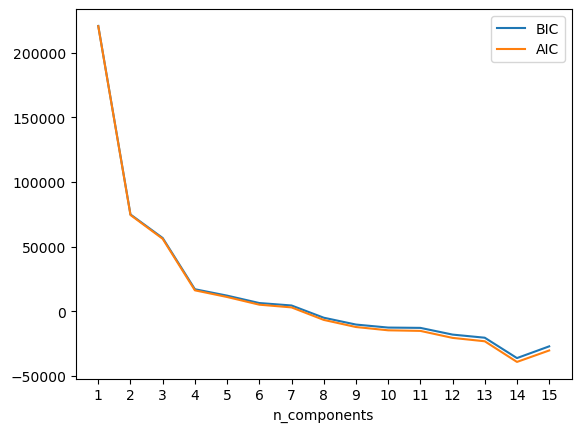

In [22]:
# Selecting number of components based on AIC and BIC
n_components = np.arange(1, 16)
models = [GaussianMixture(n, covariance_type='full', n_init=10, random_state=1).fit(df_attendance)
          for n in n_components]

# TO-DO: compute the aic and bic values for each cluster solution. Use the appropriate GMM methods.
bic_values = [gmm.bic(df_attendance) for gmm in models]
aic_values = [gmm.aic(df_attendance) for gmm in models]
plt.plot(n_components, bic_values, label='BIC')
plt.plot(n_components, aic_values, label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.xticks(n_components)
plt.show()

In [23]:
gmm = GaussianMixture(n_components=4, covariance_type='full', n_init=10, init_params='kmeans', random_state=1)
gmm_labels = gmm.fit_predict(df_attendance)
labels_proba = gmm.predict_proba(df_attendance)
gmm_labels

array([3, 3, 2, ..., 0, 2, 3])

In [24]:
Counter(gmm_labels)

Counter({0: 5104, 2: 3832, 3: 3192, 1: 2516})

In [25]:
df_concat = pd.concat([df_attendance, pd.Series(gmm_labels, index=data.index, name="gmm_labels")], axis=1)
df_concat.head()

,Age,Contract_Duration,PercentageOfVisits,PercentageOfClasses,Freq_Visits_Day,Visits_ActivePeriod,gmm_labels
0,3.083333,-0.490868,1.15,1.866571,0.763419,-0.201465,3
1,0.500000,0.285388,-0.20,0.104392,-0.204771,-0.501832,3
2,0.000000,-0.554795,0.50,0.000000,1.208748,0.619048,2
3,-1.166667,-0.257991,0.35,0.239981,0.463221,-0.300366,3
4,1.000000,1.152968,-0.50,0.000000,-0.255467,-0.600733,1


In [26]:
sst = get_ss(df_attendance)  # get total sum of squares
ssw_labels = df_concat.groupby(by='gmm_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.2279


R2 is the measure of overall proportion of variance explained by the cluster means. None of the model worked on has a good representation of the costumers.

---

# GENERAL STUDIES

In [27]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
       
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) 
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=23)
    plt.show()

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN,AgglomerativeClustering
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
import numpy as np

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

from collections import Counter
from os.path import join
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.base import clone
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import dendrogram
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
import graphviz

sns.set()

import warnings
warnings.filterwarnings("ignore")

/var/folders/x6/c7bgz3zn0hg_kdmljrfw7k_m0000gn/T/ipykernel_25898/3366181502.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [29]:
metric_test = ['Age','Contract_Duration','PercentageOfVisits', 'Freq_Visits_Day','Visits_ActivePeriod','PercentageOfClasses']

In [30]:
pca = PCA(n_components=3)
pca.fit(df_attendance)
PCA_ds = pd.DataFrame(pca.transform(df_attendance), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,14644.0,-2.911265e-17,1.401322,-2.781240,-0.924437,-0.315641,0.578596,8.952406
col2,14644.0,-1.940843e-18,1.228092,-4.302000,-0.637867,0.141428,0.601674,4.754645
col3,14644.0,-9.704217e-18,0.998236,-2.292408,-0.759801,-0.254961,0.544657,4.421053


In [31]:
#Initiating the Agglomerative Clustering model 
AC = AgglomerativeClustering(n_clusters=4)

#fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_AC

#Adding the Clusters feature to the orignal dataframe.
data["Clusters"]= yhat_AC

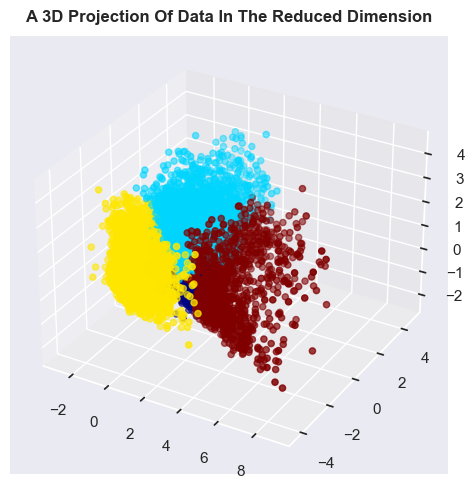

In [32]:
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]

#To plot
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c=PCA_ds['Clusters'], marker="o" ,cmap='jet')
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

In [33]:
dbscan = DBSCAN(eps = 2.1, min_samples = len(metric_test)*2)
dbscan_labels = dbscan.fit_predict(df_attendance)


dbscan_n_clusters = len(np.unique(dbscan_labels))
print("Number of estimated clusters : %d" % dbscan_n_clusters)

Counter(dbscan_labels)

Number of estimated clusters : 2


Counter({0: 14641, -1: 3})

In [34]:
gmm = GaussianMixture(n_components=4, covariance_type='full', n_init=10, init_params='kmeans', random_state=1)
gmm_labels = gmm.fit_predict(df_attendance)
labels_proba = gmm.predict_proba(df_attendance)
Counter(gmm_labels)

Counter({0: 5104, 2: 3832, 3: 3192, 1: 2516})

In [35]:
df_concat = pd.concat([df_attendance, pd.Series(gmm_labels, index=data.index, name="gmm_labels")], axis=1)
df_concat.head()

,Age,Contract_Duration,PercentageOfVisits,PercentageOfClasses,Freq_Visits_Day,Visits_ActivePeriod,gmm_labels
0,3.083333,-0.490868,1.15,1.866571,0.763419,-0.201465,3
1,0.500000,0.285388,-0.20,0.104392,-0.204771,-0.501832,3
2,0.000000,-0.554795,0.50,0.000000,1.208748,0.619048,2
3,-1.166667,-0.257991,0.35,0.239981,0.463221,-0.300366,3
4,1.000000,1.152968,-0.50,0.000000,-0.255467,-0.600733,1


In [36]:
sst = get_ss(df_attendance)  # get total sum of squares
ssw_labels = df_concat.groupby(by='gmm_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.2279


In [37]:
ag = AgglomerativeClustering(n_clusters=4,linkage='ward', metric='euclidean')
ag_labels = ag.fit_predict(df_attendance)


ag_n_clusters = len(np.unique(ag_labels))
print("Number of estimated clusters : %d" % ag_n_clusters)

Counter(ag_labels)

Number of estimated clusters : 4


Counter({0: 8599, 1: 3183, 2: 1545, 3: 1317})

In [38]:
df_concat = pd.concat([df_attendance, pd.Series(ag_labels, index=data.index, name="ag_labels")], axis=1)
df_concat.head()

,Age,Contract_Duration,PercentageOfVisits,PercentageOfClasses,Freq_Visits_Day,Visits_ActivePeriod,ag_labels
0,3.083333,-0.490868,1.15,1.866571,0.763419,-0.201465,3
1,0.500000,0.285388,-0.20,0.104392,-0.204771,-0.501832,0
2,0.000000,-0.554795,0.50,0.000000,1.208748,0.619048,0
3,-1.166667,-0.257991,0.35,0.239981,0.463221,-0.300366,0
4,1.000000,1.152968,-0.50,0.000000,-0.255467,-0.600733,0


In [39]:
sst = get_ss(df_attendance)  # get total sum of squares
ssw_labels = df_concat.groupby(by='ag_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

Cluster solution with R^2 of 0.4234


In [40]:
kmeans = KMeans(n_clusters =4 , init = 'k-means++', random_state = 88)
data["Cluster"] = kmeans.fit_predict(df_attendance)
data["Cluster"] = data["Cluster"].astype("category")
km_labels= kmeans.fit_predict(df_attendance)

In [41]:
Counter(km_labels)

Counter({1: 7670, 0: 2961, 3: 2057, 2: 1956})

In [42]:
df_concat = pd.concat([df_attendance, pd.Series(km_labels, index=data.index, name="km_labels")], axis=1)
df_concat.head()

,Age,Contract_Duration,PercentageOfVisits,PercentageOfClasses,Freq_Visits_Day,Visits_ActivePeriod,km_labels
0,3.083333,-0.490868,1.15,1.866571,0.763419,-0.201465,3
1,0.500000,0.285388,-0.20,0.104392,-0.204771,-0.501832,1
2,0.000000,-0.554795,0.50,0.000000,1.208748,0.619048,1
3,-1.166667,-0.257991,0.35,0.239981,0.463221,-0.300366,1
4,1.000000,1.152968,-0.50,0.000000,-0.255467,-0.600733,1


-----

# Check Performance and Results:

In [50]:
label = 'gmm_labels'
label_group = gmm_labels

In [60]:
data_t = pd.concat([df_attendance, pd.Series(label_group, index=data.index, name=label)], axis=1)
data_t

,Age,Contract_Duration,PercentageOfVisits,PercentageOfClasses,Freq_Visits_Day,Visits_ActivePeriod,gmm_labels
0,3.083333,-0.490868,1.15,1.866571,0.763419,-0.201465,3
1,0.500000,0.285388,-0.20,0.104392,-0.204771,-0.501832,3
2,0.000000,-0.554795,0.50,0.000000,1.208748,0.619048,2
3,-1.166667,-0.257991,0.35,0.239981,0.463221,-0.300366,3
4,1.000000,1.152968,-0.50,0.000000,-0.255467,-0.600733,1
...,...,...,...,...,...,...,...
14767,-0.166667,0.041096,-0.40,0.000000,-0.369781,-0.501832,2
14768,-0.750000,1.997717,0.65,2.056875,0.190855,1.000000,3
14769,1.333333,-0.027397,-0.25,0.000000,1.391650,0.007326,0
14770,-0.250000,-0.554795,0.85,0.000000,1.208748,1.025641,2


In [61]:
sst = get_ss(data_t[attendance_perspective])  # get total sum of squares
ssw_labels = data_t[attendance_perspective + [label]].groupby(by=label).apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
r2

0.22791016277755946

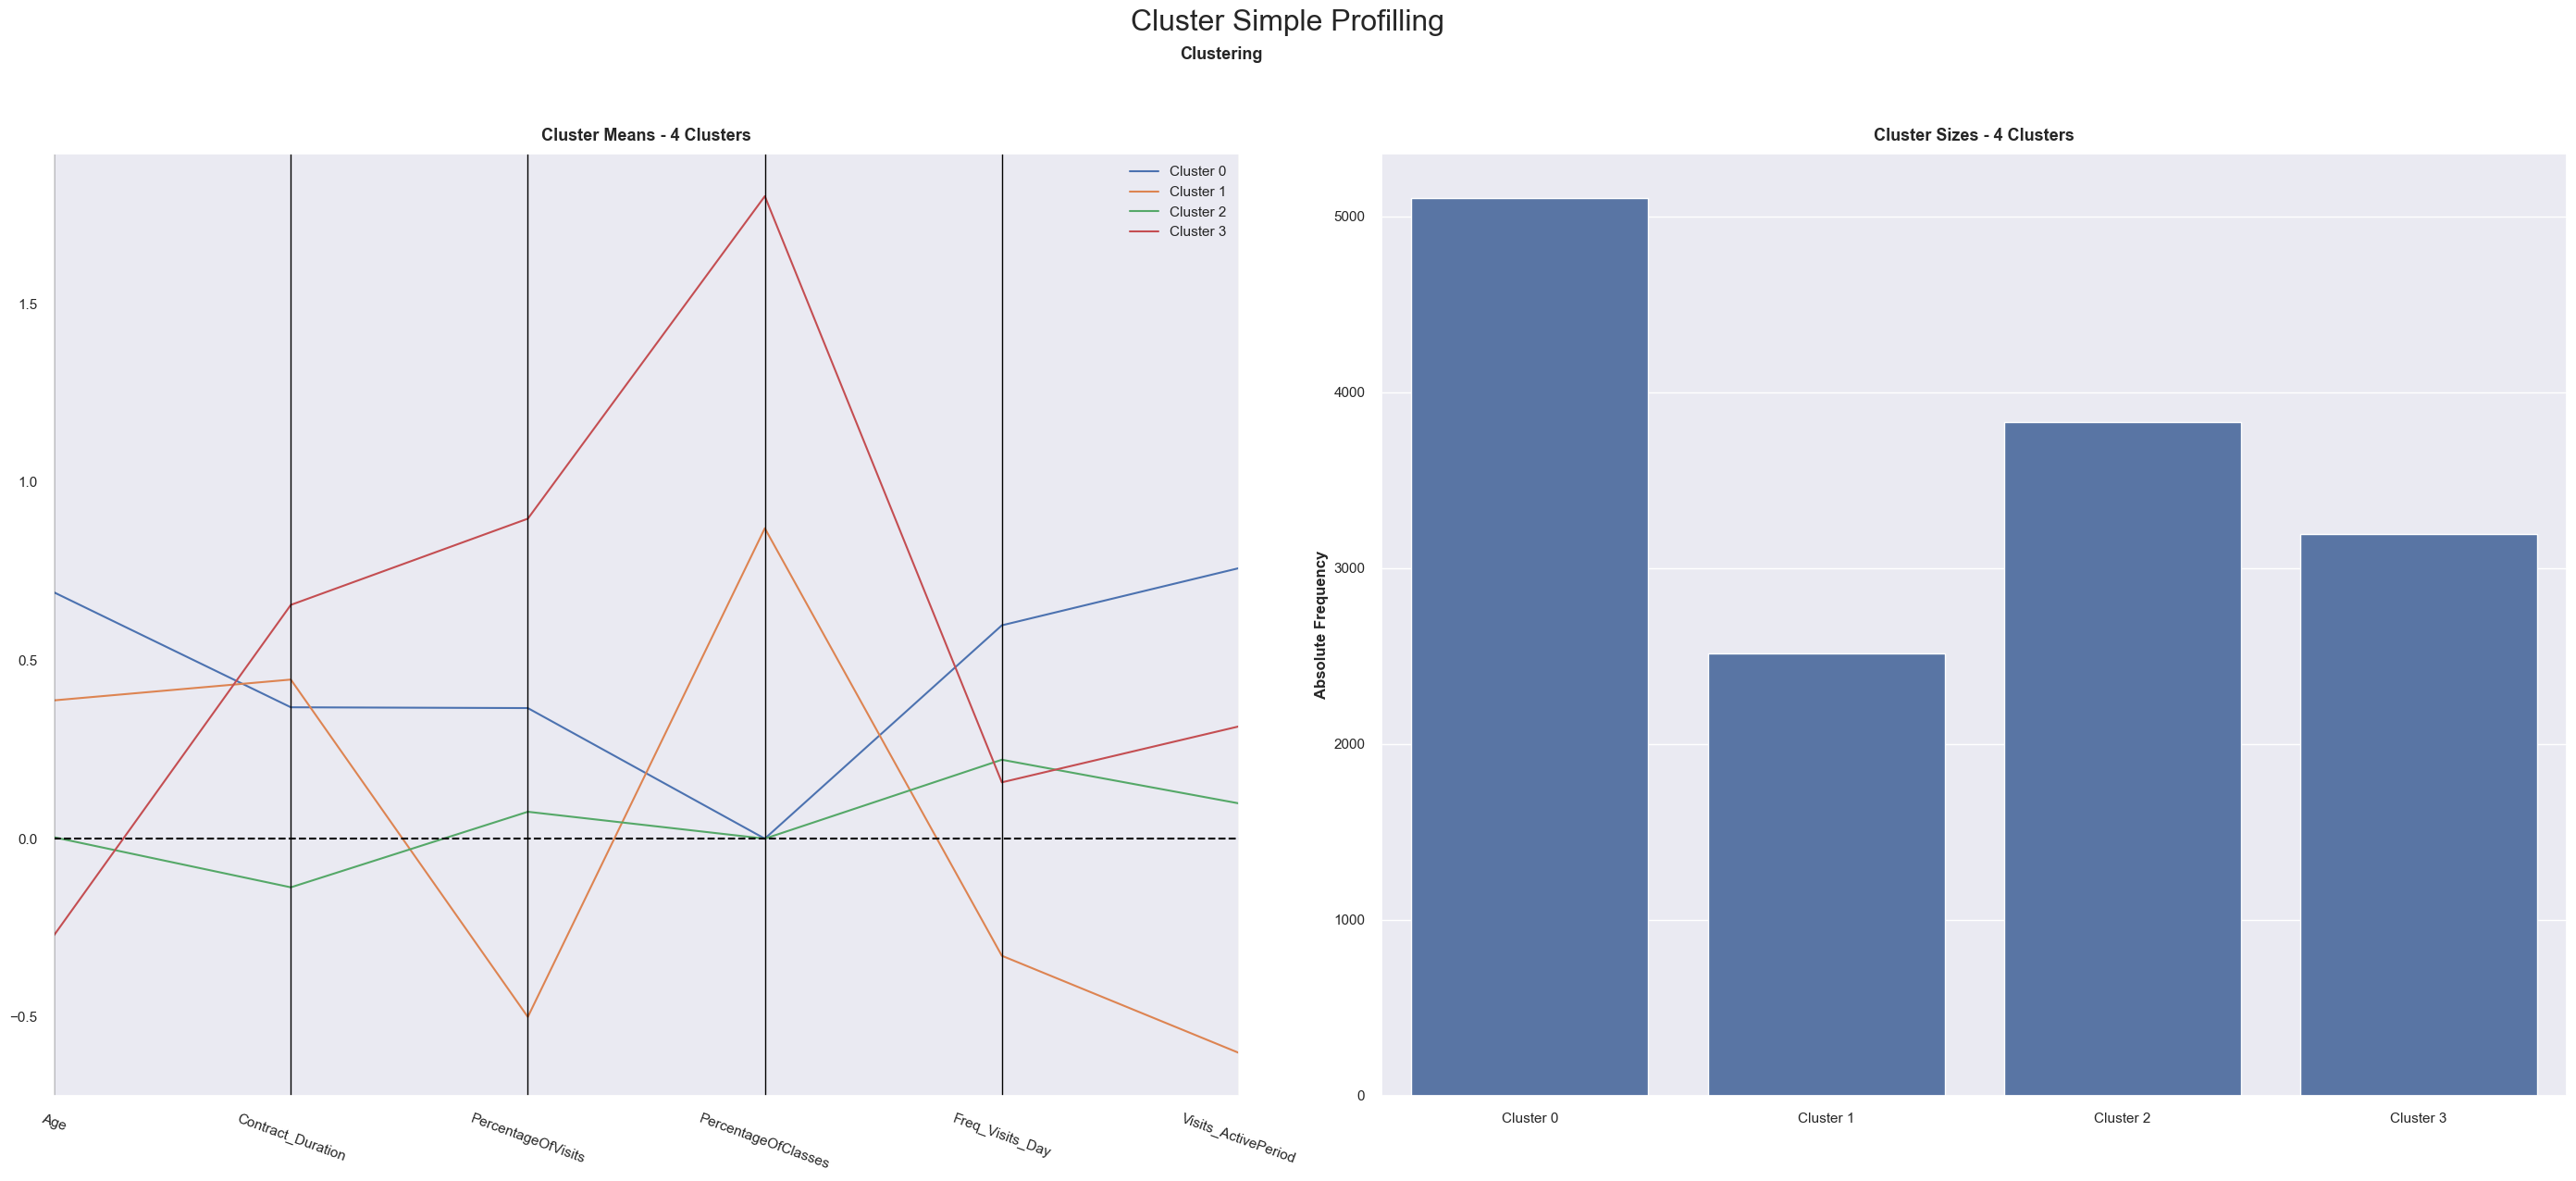

In [63]:
cluster_profiles(
    df = data_t[attendance_perspective + [label]], 
    label_columns = [label], 
    figsize = (28, 13), 
    compar_titles = ["Clustering"]
)


In [77]:
data_t = pd.concat([data, pd.Series(label_group, index=data.index, name=label)], axis=1)


In [93]:
df_educ = data_t[[label] + activities + compare].groupby([label]).sum()

In [94]:
data_t[[label]].groupby([label]).value_counts()

gmm_labels
0    5104
1    2516
2    3832
3    3192
Name: count, dtype: int64

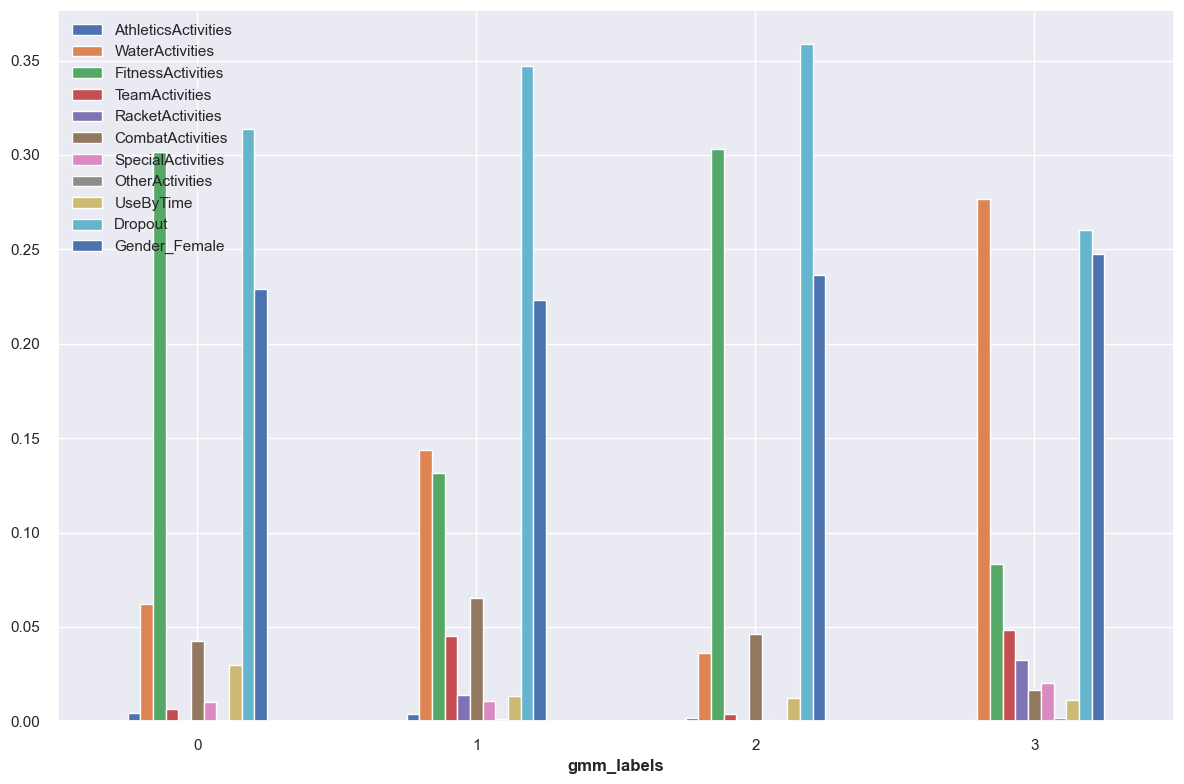

In [95]:
fig, ax = plt.subplots(figsize=(12,8))

df_educ_pct = df_educ.apply(lambda col: col/df_educ.sum(axis=1))
df_educ_pct.plot(kind='bar', stacked=False, ax=ax)
plt.xticks(rotation=0)

plt.show()

In [81]:
# This is step can be quite time consuming
two_dim = TSNE(random_state=42).fit_transform(data_t[attendance_perspective])

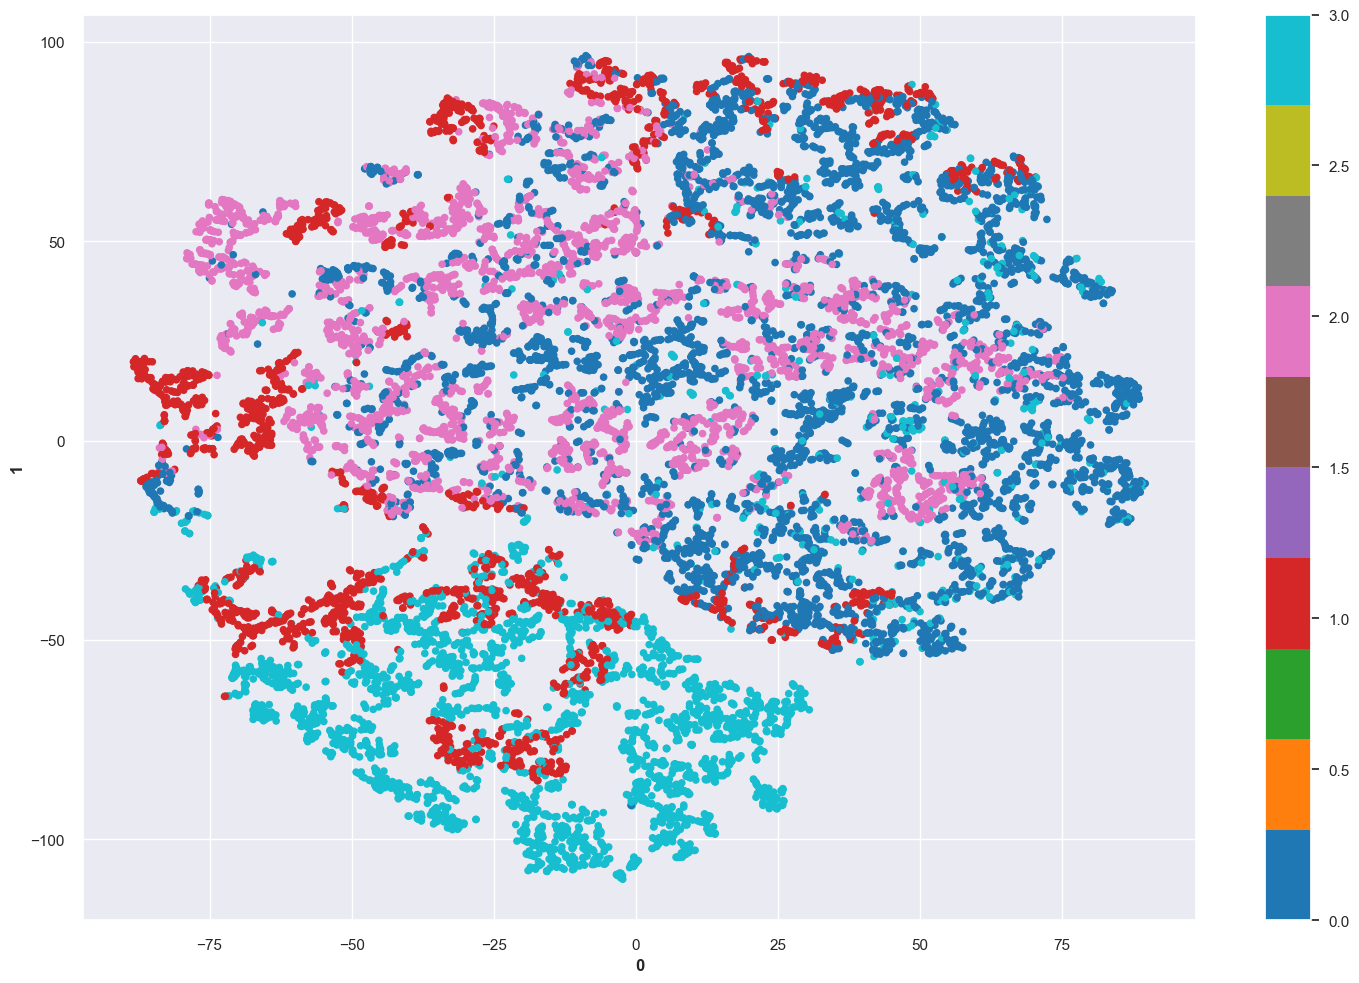

In [82]:
pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=data_t[label], colormap='tab10', figsize=(15,10))
plt.show()

In [83]:
def get_ss_variables(df):
    """Get the SS for each variable
    """
    ss_vars = df.var() * (df.count() - 1)
    return ss_vars

def r2_variables(df, labels):
    """Get the R² for each variable
    """
    sst_vars = get_ss_variables(df)
    ssw_vars = np.sum(df.groupby(labels).apply(get_ss_variables))
    return 1 - ssw_vars/sst_vars

In [90]:
# We are essentially decomposing the R² into the R² for each variable
r2_variables(data_t[attendance_perspective + [label]], label).drop(label)

Age                    0.107462
Contract_Duration      0.094781
PercentageOfVisits     0.288096
PercentageOfClasses    0.619855
Freq_Visits_Day        0.123982
Visits_ActivePeriod    0.208533
dtype: float64

-------

# Exploring other things: